Tropical Clouds and Convection: Assignment 1: Analysis of JOANNE Thermodynamic Vertical Profiles

In [2]:
import xarray as xr
import datetime
import numpy as np
import matplotlib.pyplot as plt
import eurec4a
import metpy
import metpy.calc  as mpcalc
from metpy.units import units as mpunit

# Load JOANNE dataset

In [3]:
cat = eurec4a.get_intake_catalog(use_ipfs=False)

In [4]:
ds = cat.dropsondes.JOANNE.level4.to_dask()
ds

<xarray.Dataset>
Dimensions:          (alt: 1001, sounding: 13, circle: 85)
Coordinates:
  * alt              (alt) int16 0 10 20 30 40 50 ... 9960 9970 9980 9990 10000
  * sounding         (sounding) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * circle           (circle) int64 0 1 2 3 4 5 6 7 ... 77 78 79 80 81 82 83 84
    circle_lon       (circle) float32 ...
    circle_lat       (circle) float32 ...
    circle_time      (circle) datetime64[ns] ...
    segment_id       (circle) object ...
Data variables: (12/36)
    platform_id      (circle) object ...
    flight_altitude  (circle) float32 ...
    circle_diameter  (circle) float32 ...
    u                (circle, alt) float32 ...
    dudx             (circle, alt) float32 ...
    dudy             (circle, alt) float32 ...
    ...               ...
    se_dtadx         (circle, alt) float32 ...
    se_dtady         (circle, alt) float32 ...
    se_D             (circle, alt) float32 ...
    se_vor           (circle, alt) float32 ...
    se_W             (circle, alt) float32 ...
    omega            (circle, alt) float32 ...
Attributes: (12/16)
    title:                   EUREC4A JOANNE Level-4
    doi:                     10.25326/246
    created with:            run_joanne.py doi:10.5281/zenodo.5521192
    Conventions:             CF-1.8
    campaign_id:             EUREC4A
    project_id:              JOANNE
    ...                      ...
    JOANNE_version:          2.0.0
    author:                  Geet George
    author_email:            geet.george@mpimet.mpg.de
    featureType:             trajectory
    reference:               George et al., JOANNE : Joint dropsonde Observat...
    creation_time:           2021-09-22 15:58:46.773760 UTC

In [5]:
def calc_sat_vapor_pressure(T):
    '''
    Saturation vapor pressure in mb (hPa).
    '''
    
    T_C = T - 273.15
    e_s = 6.112*np.exp(17.67*T_C/(T_C + 243.5))
    return e_s

def calc_rh(T, q, p):
    '''
    Relative humidity.
    '''
    
    eps = 0.622
    T_C = T - 273.15
    p_mb = p/100
    e_s = calc_sat_vapor_pressure(T_C)
    q_s = (eps*e_s/(p_mb-e_s))*1e3 # g/kg
    rh = q/(q_s)
    return(rh)

def calc_theta(T, p, p0=100000):
    k = 0.2854
    return(T * (p0/p)**k)

def calc_theta_v(T, q, p, p0=100000):
    k = 0.2854
    T_v = T*(1 + 0.61*q)
    theta_v = T_v * (p0/p)**k
    return theta_v

def calc_theta_e(T, q, p, p0=100000):
    L_v = 2400*1e3
    c_pd = 1005
    k = 0.2854
    theta_e = T * (p0/p)**(k)*np.exp(q*L_v/(c_pd*T))
    return(theta_e)

def calc_theta_se(T, q, p, p0=100000):
    eps = 0.622
    e_s = calc_sat_vapor_pressure(T)*100
    q_s = eps*e_s/(p-e_s)*1e3
    L_v = 2400*1e3
    c_pd = 1005
    k = 0.2854
    theta_se = T * (p0/p)**(k)*np.exp(q_s*L_v/(c_pd*T))
    return(theta_se)

def campaign_mean(ds, var):
    
    '''
    Compute the campaign mean from all dropsonde circles for specified variable.
    '''
    
    mean_var = ds[var].mean(dim='circle', keep_attrs=True)
    mean_var = mean_var.assign_attrs(name=f'mean_{var}', description=f'Campaign mean of {ds[var].name}')
    return(mean_var)


def plot_mixed_units_mean_profiles(ds, variables, max_height=None):
    
    '''
    Plot vertical profiles from campaign mean of specified variables.
    '''
    
    fig, axes = plt.subplots(1, len(variables), figsize=(2*len(variables),4), sharey=True)
    plt.subplots_adjust(top=0.95, bottom=0.06, left=0.05, right=0.95, hspace=0.3, wspace=0.1)
    
    for i, var in enumerate(variables):
        mean_var = campaign_mean(ds, var)
     
        mean_var.plot(y='alt', ax=axes[i], c='darkorchid', ylim=(0,max_height))

        if i == 0:
            axes[i].set_ylabel('Height [m]')
        else:
            axes[i].set_ylabel('')
            
        axes[i].set_xlabel(f'{var} [{ds[var].units}]')
        axes[i].grid(alpha=0.3)
        
        
def plot_same_units_mean_profiles(ds, variables, units, colors, var_labels, max_height=None):
    
    '''
    Plot vertical profiles from campaign mean of specified variables (with the same units).
    '''
    
    fig, ax = plt.subplots(1, 1, figsize=(3,5))
    plt.subplots_adjust(top=0.95, bottom=0.06, left=0.05, right=0.95, hspace=0.3, wspace=0.1)
    
    for i, var in enumerate(variables):
        
        mean_var = campaign_mean(ds, var)
     
        mean_var.plot(y='alt', c=colors[i], label=var_labels[i], ylim=(0,max_height))

        ax.set_ylabel('Height [m]')   
        ax.set_xlabel(f'[{ds[var].units}]')
        ax.grid(alpha=0.3)
        ax.legend()

# Variables from dropsondes

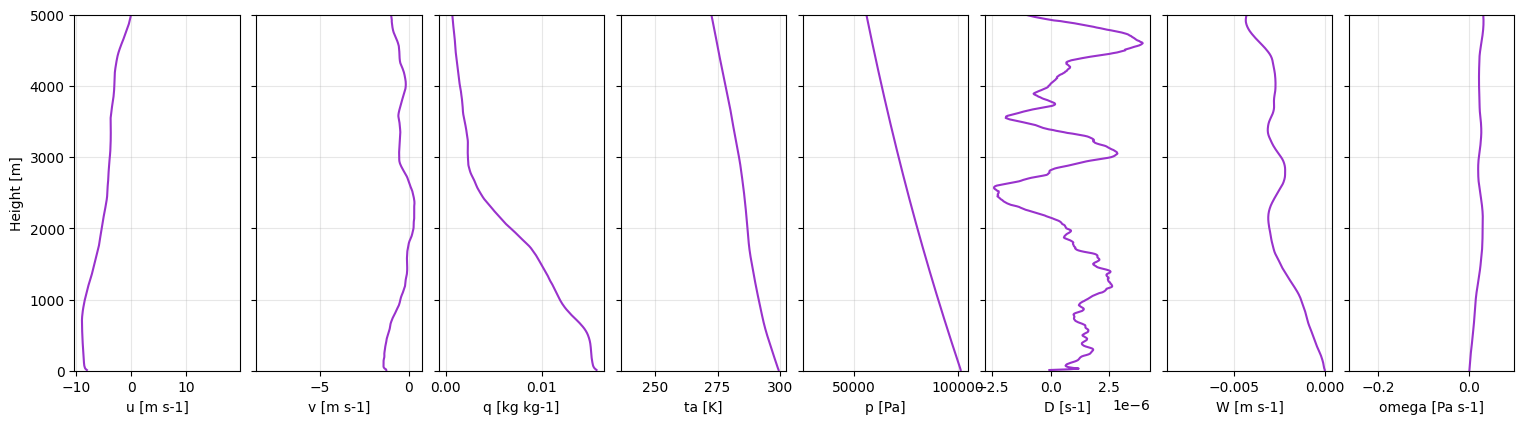

In [8]:
vars_from_dropsondes = ['u', 'v', 'q', 'ta', 'p', 'D', 'W', 'omega']

# Plot vertical profiles
plot_mixed_units_mean_profiles(ds, vars_from_dropsondes, max_height=5000)

# Potential temperatures

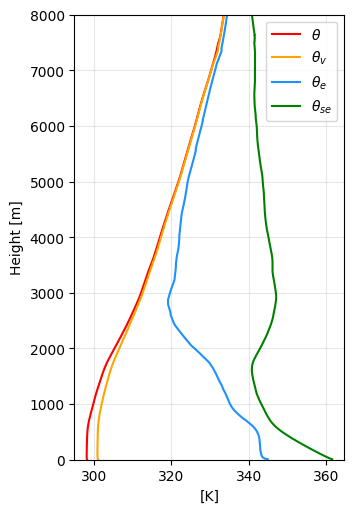

In [13]:
dewpoint      = mpcalc.dewpoint_from_specific_humidity(ds.p, ds.ta, ds.q)
mixing_ratio  = mpcalc.mixing_ratio_from_specific_humidity(ds.q)

ds['theta']    = mpcalc.potential_temperature(ds.p, ds.ta)
ds['theta_v']  = mpcalc.virtual_potential_temperature(ds.p, ds.ta, mixing_ratio)
ds['theta_e']  = mpcalc.equivalent_potential_temperature(ds.p, ds.ta, dewpoint)
ds['theta_se'] = mpcalc.saturation_equivalent_potential_temperature(ds.p, ds.ta)

ds['theta']    = ds['theta'].assign_attrs(units='K', standard_name='potential_temperature')
ds['theta_v']  = ds['theta_v'].assign_attrs(units='K', standard_name='virtual_potential_temperature')
ds['theta_e']  = ds['theta_e'].assign_attrs(units='K', standard_name='equivalent_potential_temperature')
ds['theta_se']  = ds['theta_se'].assign_attrs(units='K', standard_name='saturated_equivalent_potential_temperature')

theta_vars = ['theta', 'theta_v', 'theta_e', 'theta_se']
theta_labels = [r'$\theta$', r'$\theta_v$', r'$\theta_e$', r'$\theta_{se}$']
theta_colors = ['red', 'orange', 'dodgerblue', 'green']

plot_same_units_mean_profiles(ds, theta_vars, ds.theta.units, theta_colors, theta_labels, max_height=8000)

# Relative humidity and saturation specific humidity

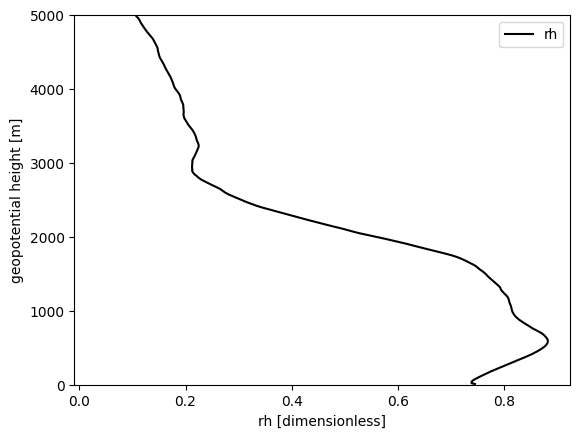

In [11]:
ds['rh'] = mpcalc.relative_humidity_from_specific_humidity(ds.p, ds.ta, ds.q).mean(dim='circle')
ds['q_s'] = (ds.q/ds.rh).mean(dim='circle')
sat_mixing_ratio = mpcalc.mixing_ratio_from_specific_humidity(ds.q_s)

ds.rh.plot(y='alt', label='rh', c='k', ylim=(0,5000))
plt.legend()

# Static Energies

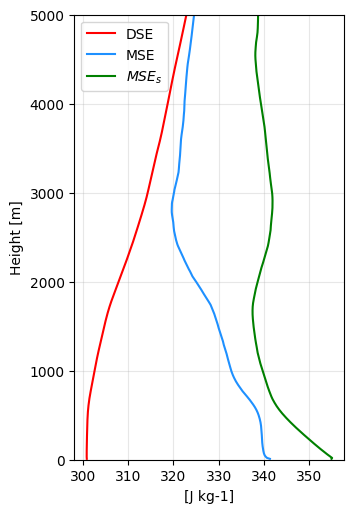

In [12]:
ds['dse']  = mpcalc.dry_static_energy(ds.alt, ds.ta)
ds['mse']  = mpcalc.moist_static_energy(ds.alt, ds.ta, mixing_ratio)
ds['mse_s'] = mpcalc.moist_static_energy(ds.alt, ds.ta, sat_mixing_ratio)

ds['dse'] = ds['dse'].assign_attrs(units='J kg-1', standard_name='dry_static_energy')
ds['mse'] = ds['mse'].assign_attrs(units='J kg-1', standard_name='moist_static_energy')
ds['mse_s'] = ds['mse_s'].assign_attrs(units='J kg-1', standard_name='saturated_moist_static_energy')

se_vars = ['dse', 'mse', 'mse_s']
se_labels = ['DSE', 'MSE', r'$MSE_s$']
se_colors = ['red', 'dodgerblue', 'green']

plot_same_units_mean_profiles(ds, se_vars, ds.dse.units, se_colors, se_labels, max_height=5000)

# Questions

## Thermodynamic variables: What are the similarities and differences of the various potential temperatures and static energies? Explain in your own words.

- __Potential temperature__: The temperature a dry air parcel would have if isentropically brought to the temeprature of the dry reference state. There is no heating from condensation and therefore it is the lowest.

- __Virtual potential temperature__: The temperature a parcel of dry air would have if it had the same density as a parcel of moist air with a water vapor mixing ratio $r$. This temperature can be used for moist air as the potential temperature is used for dry air, it allows us to use the equation of state with the gas constant of dry air (which is known). It is very similar to the dry potential temperature when there is no liquid water.

- __Equivalent potential temperature__: the temperature a parcel would have if all the moisture were to be condensed out and the parcel were to be brought to the level of reference pressure. This temperature is useful because it remains constant in a moist parcel during changes in pressure (as it moves up in the atmopshere, for example), even if there is condensation of water vapor. This is in contrast to the virtual potential temperature, which only remains constant if no water condenses. When there is no moisture, the equivalent potential temperature is the same as the dry potential temperature.

- __Saturation equivalent potential temperature__: this is a case of the equivalent potential temperature, if the air parcel is saturated with water vapor. It corresponds to the maximum equivalent potential temperature. The equivalent potential temperatures (normal and saturated) are both cases of potential temperature for which the latent heat of condensation is taken into account to increase or decrease the temperature. 

- __Dry static energy__: it is the energy composed of the sum of potential energy and heat, by assuming that all kinetic energy is converted to heat. This energy is a similar concept to potential temperature, because it is conserved for adiabatic motions in the atmosphere.

- __Moist static energy__: similar to the equivalent potential temperature, the moist static energy is the energy a parcel would have if it were adiabatically lifted to a reference pressure and if all the water vapor were to be condensed out. It therefore takes into account the energy from heat released by condensation, as opposed to the dry static energy.

- __Saturation moist static energy__: it is the same as the moist static energy if the parcel was saturated, therefore a similar concept as the saturation equivalent potential temperature. 

## Mesoscale vertical velocity: How are the area-averaged mass divergence D, the vertical velocity W and the pressure velocity ω related? How can you compute the latter two from the former?


Large scale divergence is related to the vertical velocity through the conservation of mass. Divergence is associated with subsidence, and convergence (negative divergence) is associated with updrafts. We do not always see this relationship in the circle average profiles, but perhaps it is difficult to relate them when the average has been done over such a long time period, and this relationship is more visible over averages of a few hours.

The area-averaged mass divergence $D$ is computed from the gradients in large scale horizontal wind velocities in $x$ and $y$ as: 

$$
D = \frac{\partial\bar{u}}{\partial x} + \frac{\partial\bar{v}}{\partial y}
$$

or

$$
D = \frac{1}{A} \oint V_n dl
$$

where A is the area covered by the circles and V_n is the horizontal wind component. In order to get the horizontal changes in the wind velocities, one needs a 2D field of observations. This is why to calculate divergence it is necessary to look at the area encircled by the dropsondes, and why it is an area-averaged quantity.

From the principle of mass continuity:

$$
\frac{\partial\bar{u}}{\partial x} + \frac{\partial\bar{v}}{\partial y} + \frac{\partial\bar{w}}{\partial z} = 0
$$

and following Bony and Stevens (2019), we can write the large scale vertical wind as:

$$
\bar{w}(z) = - \int^z_0 D dz
$$

The vertical wind can thus be computed from the horizontal winds, if 2-dimensional data (or an average, as in the dropsonde circle case) is available. 

Lastly, the pressure velocity is the vertical wind speed in pressure space, instead of altitude space. It can be computed from the vertical velocity, the density, and gravity as:

$$
\omega (z) = -\rho(z) g w(z)
$$

## Vertical Structure: 

###### Can you identify the different layers characterizing the vertical structure of the trade-wind boundary layer? At which heights can you find the mixed layer, the transition layer, the cloud layer, the inversion layer and the free troposphere?

- The mixed layer is at about 500 m, related to the constant specific humidity and potential temperature with height. The transition layer spans from 500m to 700m and it is related to the peak in RH right below the cloud layer and it is a stable layer that inhibits convection (decreasing temperature with height). The cloud layer starts above the transition layer, at the lifting condensation level, and spans up to the inversion layer, where the clouds cannot continue to grow; it is most evident from the RH profile, which decreases drastically as the water vapor condenses, and increases again at the top of the cloud layer, and from the MSE/$\theta_e$, which decrease throughout the cloud layer due to condensation (less water vapor to condense in the air means lower MSE/$\theta_e$). The inversion layer is at ~3000m, guessing from the shift to increasing equivalent potential temperature and MSE, and it caps cloud growth. The free troposphere starts at ~3200m.

###### In which variables are these layers most clearly evident? And in which not?

- The layers are most clearly visible in the moisture, equivalent potential temperature, moist static energy, and relative humidity. From the temperature profile one can distinguish the inversion layer, but not the others so clearly. It is difficult to extract the layers in the rest of the profiles as ther are very variable with height. Perhaps doivergence and convergence could be used to distinguish the cloud and subcloud layers.

###### What is the reason for the minimum in MSE and $\theta_e$ just above the inversion layer? What does the relative position of MSE between DSE and MSEs measure?

- The MSE and $\theta_e$ measure the energy and temperature of a parcel whose moisture has been condensed out. Therefore they are lower when there is a lower amount of water vapor available in the parcel. At this point, most water vapor has been condensed in the lower layers to form clouds. They both start to increase above the inversion layer because the atmosphere is dry and there is a higher heat content. Heat to these levels can also come from hot towers that overshoot the inversion layer. The position of MSE between DSE and MSEs is due to the MSE accounting for the latent heat release from condensation (which does not appear in the DSE), and the MSEs being the maximum possible energy (since the atmosphere is saturated with water vapor.

# Wikipedia

## Summary of key principles of writing a Wikipedia article

- A Wikipedia article serves to inform the general public about very specific topics. It needs to be based on facts drawn from reviewed literature, and must not represent one's own point of view. While everything that is written in a wikipedia article must be cited (and these citations need to be published, refereed research, which is not one's own), it is also important not to plagiarize other people's work, and thus must be written in one's own words. The article should be written in the same style as other Wikipedia articles, and inclue figures, to make it easier for readers to follow.

## Choose an article. Does it comply with the Wikipedia principles?

- I chose the article on cumulus clouds. The article begins with a lead section, which includes a concise definition of cumulus clouds, including the etimology, followed by a complete but brief summary of their formation, properties, and position in the larger groups of clouds, preparing the reader for what will be explained in more detail in the following sections. A side box (Infobox) with an image and a list of the main properties makes it easy to get the main properties at a glance. The body of the article is very well structured with a section for each of the aspects of the clouds that could be discussed: formation, description, forecast, effect on the climate, and relation to other clouds. This makes it easy for the reader to jump to a specific section if they are just looking to learn about a certain aspect of the clouds, and makes the information easier to navigate. There are many images that help to visualize the clouds, but perhaps a diagram explaining the formation and physical properties to help visual learners is missing. Finally, the article is very well documented with a wide range of references, which are listed and easily accessible at the end of the article.